In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import nltk
import nltk as nlp
import string
import re

In [2]:
import sys
!{sys.executable} -m pip install spacy

In [3]:
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

In [4]:
!{sys.executable} -m pip install psycopg2

In [4]:
import psycopg2
conn = psycopg2.connect(dbname='vknews', user='postgres', 
                        password='password', host='172.17.0.2')
cursor = conn.cursor()

In [5]:
cursor.execute('SELECT * FROM groups')
records = cursor.fetchall()
groups = list(records)
groups

[(76982440, 'meduzaproject', '«Медуза»', 713584),
 (15755094, 'ria', 'РИА Новости', 2503096),
 (23482909, 'kommersant_ru', 'Коммерсантъ', 329574),
 (28261334, 'tj', 'TJ', 702539),
 (25232578, 'rbc', 'РБК', 767882)]

In [6]:
groups_df = pd.DataFrame({
    'name': [group[2] for group in groups],
    'screen_name': [group[1] for group in groups],
    'members_count': [group[3] for group in groups]
})
groups_df

,name,screen_name,members_count
0,«Медуза»,meduzaproject,713584
1,РИА Новости,ria,2503096
2,Коммерсантъ,kommersant_ru,329574
3,TJ,tj,702539
4,РБК,rbc,767882


In [7]:
cursor.execute('SELECT * FROM posts')
records = cursor.fetchall()
posts = list(records)
len(posts)

1230

In [8]:
posts[0]

(1719061,
 'kommersant_ru',
 datetime.datetime(2020, 6, 15, 13, 0, 42),
 '«Вновь обрести Францию»',
 'Президент Эмманюэль Макрон анонсировал план выхода из кризиса',
 8,
 3207,
 2,
 1)

In [24]:
title_list = [post[3] for post in posts]
text_list = [post[4] for post in posts]
group_list = [post[1] for post in posts]

In [95]:
news = pd.DataFrame(data={'title': title_list, 'text': text_list, 'group': group_list})
news

,title,text,group
0,«Вновь обрести Францию»,Президент Эмманюэль Макрон анонсировал план вы...,kommersant_ru
1,Откопалипсис сегодня,В сети вышли «Пятеро одной крови» Спайка Ли,kommersant_ru
2,У снайпера проявились недетские чувства,Морпеха осудили за сексуальные действия на «гр...,kommersant_ru
3,Голикова: пик заражения COVID-19 в России приш...,Подробнее на сайте,kommersant_ru
4,Член псковского избиркома предложила застрахов...,Член избирательной комиссии Псковской области ...,meduzaproject
...,...,...,...
1225,Что смотреть подросткам и с подростками: «Четы...,В рубрике «Домашний кинотеатр» «Медуза» расска...,meduzaproject
1226,"«Суду нужно совершить ритуал, жертвоприношение...",17 июня в Петербурге начинаются судебные прени...,meduzaproject
1227,"Всем интересно, где же будут «мужские разборки...",15 июня спортсмен Евгений Плющенко и оппозицио...,meduzaproject
1228,Схиигумен Сергий ответил на обвинения в захват...,Схиигумен Сергий (Сергей Романов) ответил на о...,ria


In [26]:
def unique(text):
    for word in text:
        text = text.split()
        text = set(text)
        return text
unique("i am going and i will go by bus")

{'am', 'and', 'bus', 'by', 'go', 'going', 'i', 'will'}

In [28]:
def remove_numbers(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text
remove_numbers("I am 20 years")

'I am  years'

In [29]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL("Kaggle id https://www.kaggle.com/vanshjatana")

'Kaggle id '

In [30]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
remove_html("<h1>Vansh Jatana</h1>")

'Vansh Jatana'

In [31]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Sad😔")

'Sad'

In [32]:
!{sys.executable} -m pip install pymorphy2

In [34]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

pattern = re.compile(r'\W')
def pos(word, morth=pymorphy2.MorphAnalyzer()):
    "Return a likely part of speech for the *word*."""
    return morth.parse(word)[0].tag.POS

functors_pos = {'INTJ', 'PRCL', 'CONJ', 'PREP'}  # function words
print('Without pretext:')
words = [pattern.sub('', word) for word in title_list[0].split() if pos(word) not in functors_pos]
print(*words)
print('Normal forms:')
words = [morph.normal_forms(w)[0] for w in words]
print(' '.join(words))

Without pretext:
Вновь обрести Францию
Normal forms:
вновь обрести франция


In [65]:
pattern = re.compile(r'\W')
notdigit = re.compile(r'\D')

def text_pipeline(text: str) -> list:
    morph = pymorphy2.MorphAnalyzer()
    functors_pos = {'INTJ', 'PRCL', 'CONJ', 'PREP'}  # function words
    pos = lambda word: morph.parse(word)[0].tag.POS
    words = [pattern.sub('', word) for word in text.split() if pos(word) not in functors_pos]
    words = [word for word in words if notdigit.match(word)]
    words = [morph.normal_forms(w)[0] for w in words]
    return ' '.join(words)

text_pipeline('Бизнесмена из «списка Титова» вопреки обещания посадили на 20 суток.')

'бизнесмен список титов обещание посадить сутки'

In [58]:
!{sys.executable} -m pip install wordcloud
from wordcloud import WordCloud, ImageColorGenerator

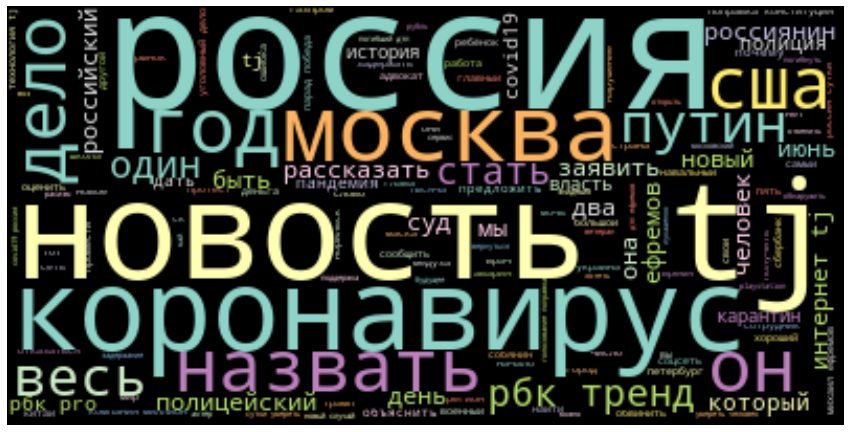

In [67]:
text = ''
for title in title_list:
    title = text_pipeline(title)
    text += title + ' '
wordcloud = WordCloud(max_words=200,colormap='Set3', background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

In [96]:
news['likes_count'] = [post[5] for post in posts]
news['views_count'] = [post[6] for post in posts]
news['comments_count'] = [post[7] for post in posts]
news['reposts_count'] = [post[8] for post in posts]
news['processed_title'] = [text_pipeline(title) for title in news['title']]
news

,title,text,group,likes_count,views_count,comments_count,reposts_count,processed_title
0,«Вновь обрести Францию»,Президент Эмманюэль Макрон анонсировал план вы...,kommersant_ru,8,3207,2,1,вновь обрести франция
1,Откопалипсис сегодня,В сети вышли «Пятеро одной крови» Спайка Ли,kommersant_ru,5,2562,0,2,откопалипсис сегодня
2,У снайпера проявились недетские чувства,Морпеха осудили за сексуальные действия на «гр...,kommersant_ru,7,3214,1,1,снайпер проявиться недетский чувство
3,Голикова: пик заражения COVID-19 в России приш...,Подробнее на сайте,kommersant_ru,9,5501,8,0,голиков пик заражение covid19 россия прийтись май
4,Член псковского избиркома предложила застрахов...,Член избирательной комиссии Псковской области ...,meduzaproject,86,34631,36,4,член псковский избирком предложить застраховат...
...,...,...,...,...,...,...,...,...
1225,Что смотреть подросткам и с подростками: «Четы...,В рубрике «Домашний кинотеатр» «Медуза» расска...,meduzaproject,158,36587,27,21,смотреть подросток подросток четыреста удар чу...
1226,"«Суду нужно совершить ритуал, жертвоприношение...",17 июня в Петербурге начинаются судебные прени...,meduzaproject,60,23647,13,3,суд нужно совершить ритуал жертвоприношение пе...
1227,"Всем интересно, где же будут «мужские разборки...",15 июня спортсмен Евгений Плющенко и оппозицио...,meduzaproject,214,41972,81,4,весь интересно где быть мужской разборка навал...
1228,Схиигумен Сергий ответил на обвинения в захват...,Схиигумен Сергий (Сергей Романов) ответил на о...,ria,41,21479,65,2,схиигумен сергий ответить обвинение захват мон...


In [71]:
from sklearn.feature_extraction.text import CountVectorizer
print('Text len: ', len(text))
vectorizer = CountVectorizer()
vectorizer.fit([text])
print('Vocabulary len: ', len(vectorizer.vocabulary_), '\n', list(vectorizer.vocabulary_.items())[:10], sep='')

Text len:  78500
Vocabulary len: 3537
[('вновь', 486), ('обрести', 1814), ('франция', 3331), ('откопалипсис', 1955), ('сегодня', 2766), ('снайпер', 2868), ('проявиться', 2499), ('недетский', 1700), ('чувство', 3431), ('голиков', 689)]


In [72]:
sorted_d = {k: v for k, v in sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1], reverse=True)}
list(sorted_d.items())[:10]

[('ясный', 3536),
 ('ясно', 3535),
 ('японец', 3534),
 ('яндекстелемост', 3533),
 ('яндекстакси', 3532),
 ('яндекскуколд', 3531),
 ('яндекседа', 3530),
 ('яндекс', 3529),
 ('ям', 3528),
 ('якутск', 3527)]

In [73]:
counts = [item[1] for item in sorted_d.items()]
print('Len: ', len(counts), '\n', counts[:10], sep='')

Len: 3537
[3536, 3535, 3534, 3533, 3532, 3531, 3530, 3529, 3528, 3527]


In [74]:
labels = [item[0] for item in sorted_d.items()]
print('Len: ', len(labels), '\n', labels[:10], sep='')

Len: 3537
['ясный', 'ясно', 'японец', 'яндекстелемост', 'яндекстакси', 'яндекскуколд', 'яндекседа', 'яндекс', 'ям', 'якутск']


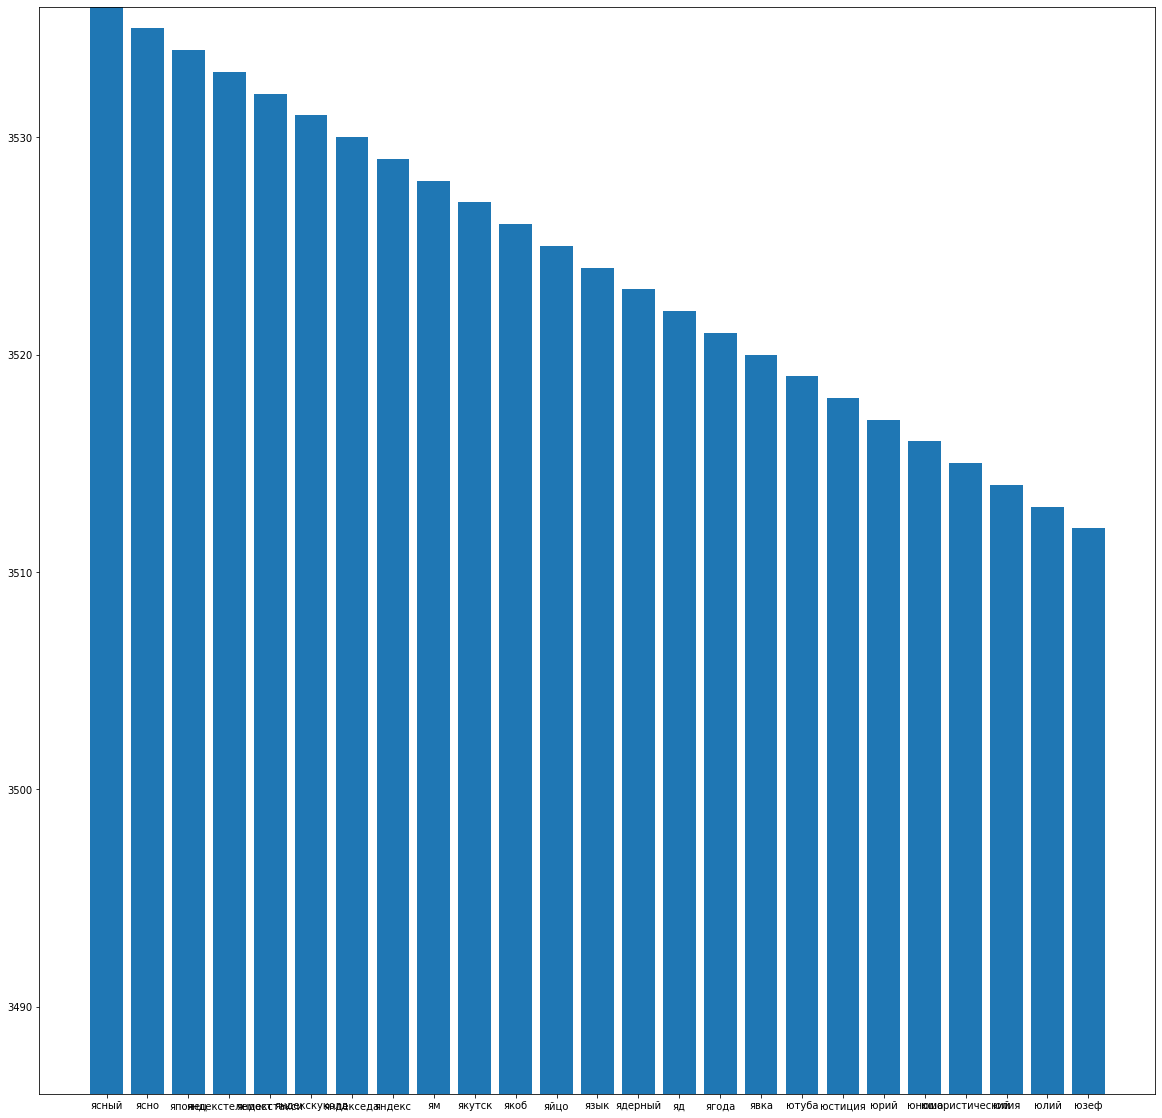

In [75]:
COUNT = 25
plt.subplots(figsize=(20,20))
plt.bar(range(len(counts[:COUNT])), counts[:COUNT])
plt.xticks(range(len(counts[:COUNT])), tuple(labels[:COUNT]))
plt.ylim(ymax = counts[0], ymin = counts[COUNT * 2])
plt.show()

In [76]:
news['processed_title'][0]

'вновь обрести франция'

In [77]:
vectorized_title = vectorizer.transform(news['processed_title'])
vectorized_title

<1230x3537 sparse matrix of type '<class 'numpy.int64'>'
	with 9637 stored elements in Compressed Sparse Row format>

In [78]:
print(len(vectorizer.vocabulary_))

3537


In [79]:
for i, col in enumerate(vectorizer.get_feature_names()):
    news[col] = pd.Series(pd.arrays.SparseArray(vectorized_title[:, i].toarray().ravel(), fill_value=0))
news

,title,text,title_unq,group,likes_count,views_count,comments_count,reposts_count,likes_to_views,processed_title,...,якутск,ям,яндекс,яндекседа,яндекскуколд,яндекстакси,яндекстелемост,японец,ясно,ясный
0,«Вновь обрести Францию»,Президент Эмманюэль Макрон анонсировал план вы...,"{обрести, «Вновь, Францию»}",0,8,3207,2,1,0.002495,вновь обрести франция,...,0,0,0,0,0,0,0,0,0,0
1,Откопалипсис сегодня,В сети вышли «Пятеро одной крови» Спайка Ли,"{Откопалипсис, сегодня}",0,5,2562,0,2,0.001952,откопалипсис сегодня,...,0,0,0,0,0,0,0,0,0,0
2,У снайпера проявились недетские чувства,Морпеха осудили за сексуальные действия на «гр...,"{снайпера, У, проявились, недетские, чувства}",0,7,3214,1,1,0.002178,снайпер проявиться недетский чувство,...,0,0,0,0,0,0,0,0,0,0
3,Голикова: пик заражения COVID-19 в России приш...,Подробнее на сайте,"{на, в, пик, COVID-19, Голикова:, заражения, п...",0,9,5501,8,0,0.001636,голиков пик заражение covid19 россия прийтись май,...,0,0,0,0,0,0,0,0,0,0
4,Член псковского избиркома предложила застрахов...,Член избирательной комиссии Псковской области ...,"{псковского, Член, застраховать, избиркома, на...",0,86,34631,36,4,0.002483,член псковский избирком предложить застраховат...,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,Что смотреть подросткам и с подростками: «Четы...,В рубрике «Домашний кинотеатр» «Медуза» расска...,"{детстве, «Джуно», фильмов, смотреть, и, перво...",0,158,36587,27,21,0.004318,смотреть подросток подросток четыреста удар чу...,...,0,0,0,0,0,0,0,0,0,0
1226,"«Суду нужно совершить ритуал, жертвоприношение...",17 июня в Петербурге начинаются судебные прени...,"{обвиняемого, «Суду, еще, В, Бояршиновым, отцо...",0,60,23647,13,3,0.002537,суд нужно совершить ритуал жертвоприношение пе...,...,0,0,0,0,0,0,0,0,0,0
1227,"Всем интересно, где же будут «мужские разборки...",15 июня спортсмен Евгений Плющенко и оппозицио...,"{жаль, всем, же, Навального, гаражами?, Всем, ...",0,214,41972,81,4,0.005099,весь интересно где быть мужской разборка навал...,...,0,0,0,0,0,0,0,0,0,0
1228,Схиигумен Сергий ответил на обвинения в захват...,Схиигумен Сергий (Сергей Романов) ответил на о...,"{обвинения, ответил, Сергий, на, монастыря, в,...",0,41,21479,65,2,0.001909,схиигумен сергий ответить обвинение захват мон...,...,0,0,0,0,0,0,0,0,0,0


In [80]:
news.iloc[:, 12:]

,amazon,androidсмартфон,app,apple,ar,aramco,badcomedian,band,bazaar,big,...,якутск,ям,яндекс,яндекседа,яндекскуколд,яндекстакси,яндекстелемост,японец,ясно,ясный
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1226,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1227,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1228,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
for column in news.columns[-20:]:
    print('Word: ', column)
    print('Likes: ', news[news[column]==1]['likes_count'].sum())
    print('Views: ', news[news[column]==1]['views_count'].sum())
    print('Comments: ', news[news[column]==1]['comments_count'].sum())
    print('Reposts: ', news[news[column]==1]['reposts_count'].sum(), end='\n\n')

Word:  юрий
Likes:  180
Views:  61313
Comments:  77
Reposts:  6

Word:  юстиция
Likes:  73
Views:  37196
Comments:  42
Reposts:  3

Word:  ютуба
Likes:  92
Views:  21084
Comments:  30
Reposts:  3

Word:  явка
Likes:  2
Views:  3044
Comments:  1
Reposts:  0

Word:  ягода
Likes:  3
Views:  2249
Comments:  0
Reposts:  0

Word:  яд
Likes:  119
Views:  77567
Comments:  75
Reposts:  5

Word:  ядерный
Likes:  26
Views:  17974
Comments:  49
Reposts:  2

Word:  язык
Likes:  284
Views:  104632
Comments:  556
Reposts:  7

Word:  яйцо
Likes:  212
Views:  42609
Comments:  9
Reposts:  17

Word:  якоб
Likes:  0
Views:  1077
Comments:  0
Reposts:  0

Word:  якутск
Likes:  239
Views:  32778
Comments:  19
Reposts:  2

Word:  ям
Likes:  168
Views:  33970
Comments:  21
Reposts:  4

Word:  яндекс
Likes:  337
Views:  116679
Comments:  238
Reposts:  8

Word:  яндекседа
Likes:  6
Views:  2691
Comments:  0
Reposts:  1

Word:  яндекскуколд
Likes:  138
Views:  32629
Comments:  152
Reposts:  0

Word:  яндекстакси

In [99]:
news['comments2views'] = news['comments_count'] / news['views_count']
news['likes2views'] = news['likes_count'] / news['views_count']
news['date'] = [post[2] for post in posts]
news

,title,text,group,likes_count,views_count,comments_count,reposts_count,processed_title,comments2views,likes2views,date
0,«Вновь обрести Францию»,Президент Эмманюэль Макрон анонсировал план вы...,kommersant_ru,8,3207,2,1,вновь обрести франция,0.000624,0.002495,2020-06-15 13:00:42
1,Откопалипсис сегодня,В сети вышли «Пятеро одной крови» Спайка Ли,kommersant_ru,5,2562,0,2,откопалипсис сегодня,0.000000,0.001952,2020-06-15 22:50:05
2,У снайпера проявились недетские чувства,Морпеха осудили за сексуальные действия на «гр...,kommersant_ru,7,3214,1,1,снайпер проявиться недетский чувство,0.000311,0.002178,2020-06-15 14:00:34
3,Голикова: пик заражения COVID-19 в России приш...,Подробнее на сайте,kommersant_ru,9,5501,8,0,голиков пик заражение covid19 россия прийтись май,0.001454,0.001636,2020-06-13 09:37:11
4,Член псковского избиркома предложила застрахов...,Член избирательной комиссии Псковской области ...,meduzaproject,86,34631,36,4,член псковский избирком предложить застраховат...,0.001040,0.002483,2020-06-12 17:27:31
...,...,...,...,...,...,...,...,...,...,...,...
1225,Что смотреть подросткам и с подростками: «Четы...,В рубрике «Домашний кинотеатр» «Медуза» расска...,meduzaproject,158,36587,27,21,смотреть подросток подросток четыреста удар чу...,0.000738,0.004318,2020-06-15 17:40:53
1226,"«Суду нужно совершить ритуал, жертвоприношение...",17 июня в Петербурге начинаются судебные прени...,meduzaproject,60,23647,13,3,суд нужно совершить ритуал жертвоприношение пе...,0.000550,0.002537,2020-06-17 08:44:03
1227,"Всем интересно, где же будут «мужские разборки...",15 июня спортсмен Евгений Плющенко и оппозицио...,meduzaproject,214,41972,81,4,весь интересно где быть мужской разборка навал...,0.001930,0.005099,2020-06-16 13:38:39
1228,Схиигумен Сергий ответил на обвинения в захват...,Схиигумен Сергий (Сергей Романов) ответил на о...,ria,41,21479,65,2,схиигумен сергий ответить обвинение захват мон...,0.003026,0.001909,2020-06-17 10:40:16


In [106]:
# Most discussed news
news.sort_values(by=['comments2views'], ascending=False).head(10)

,title,text,group,likes_count,views_count,comments_count,reposts_count,processed_title,comments2views,likes2views,date
649,Путин ответил на критику поправок в Конституцию,"Владимир Путин не согласился с мнением о том, ...",ria,224,72487,912,15,путин ответить критика поправка конституция,0.012582,0.003090,2020-06-14 12:56:16
786,В РПЦ поддержали предложение омбудсмена об огр...,Митрополит Иларион счел «хромой логикой» мнени...,rbc,104,45699,559,11,рпц поддержать предложение омбудсмен ограничен...,0.012232,0.002276,2020-06-14 09:27:36
216,В России за сутки от коронавируса умерли 183 ч...,Подробнее на сайте,kommersant_ru,58,30414,351,3,россия сутки коронавирус умереть человек,0.011541,0.001907,2020-06-12 08:53:38
373,Путин заявил о поддержке поправок «абсолютным ...,Поправки в Конституцию разделяет большинство г...,rbc,88,36077,401,8,путин заявить поддержка поправка абсолютный бо...,0.011115,0.002439,2020-06-12 12:00:13
904,В Симферополе передумали отменять парад Победы...,За два с половиной часа глава Крыма «взвесил в...,rbc,90,30698,326,5,симферополь передумать отменять парад победа июнь,0.010620,0.002932,2020-06-16 13:30:02
1023,«Общество в истории Ефремова стремится взять с...,Адвокат Александр Пиховкин — о реакции россиян...,kommersant_ru,9,3644,38,2,общество история ефремов стремиться взять спра...,0.010428,0.002470,2020-06-16 09:00:52
210,Путин: большинство россиян поддерживают поправ...,Подробнее на сайте,kommersant_ru,38,11759,121,4,путин большинство россиянин поддерживать попра...,0.010290,0.003232,2020-06-12 11:37:06
577,Путин назвал поправки в Конституцию шагом к де...,В новом варианте Конституции часть «очень суще...,rbc,122,39397,369,11,путин назвать поправка конституция шагом демок...,0.009366,0.003097,2020-06-14 13:35:59
584,В России за сутки коронавирус выявили у 8835 ч...,За последние сутки в России выявлено 8835 забо...,meduzaproject,206,85016,779,5,россия сутки коронавирус выявить человек начал...,0.009163,0.002423,2020-06-14 07:55:06
415,За 20 лет доля «безусловных» патриотов России ...,"С 2000 по 2020 год доля россиян, называвших се...",rbc,104,27938,254,12,год доля безусловный патриот россия снизиться ...,0.009092,0.003723,2020-06-11 14:15:00


In [107]:
# Most liked news
news.sort_values(by=['likes2views'], ascending=False).head(10)

,title,text,group,likes_count,views_count,comments_count,reposts_count,processed_title,comments2views,likes2views,date
15,Возвращаем 2007-й,Playlist,meduzaproject,1544,83460,76,208,возвращать,0.000911,0.018500,2020-06-13 17:27:00
18,Twitter заблокировал больше тысячи аккаунтов з...,Социальная сеть Twitter заблокировала более 32...,meduzaproject,930,60504,210,11,twitter заблокировать большой тысяча аккаунт п...,0.003471,0.015371,2020-06-12 17:47:31
1108,Трансгендерная женщина отсудила два миллиона р...,Городской суд Санкт-Петербурга утвердил решени...,meduzaproject,772,51577,170,10,трансгендерный женщина отсудить два миллион ру...,0.003296,0.014968,2020-06-16 16:08:40
90,"«Поедешь на зону на пять лет, хочешь? Просто т...",В Москве сотрудника Росгвардии привлекли к адм...,meduzaproject,708,57588,189,31,поехать зона пять год хотеть так сотрудник рос...,0.003282,0.012294,2020-06-11 10:12:16
126,ФБК нашел у семьи главы Росприроднадзора недви...,Семья главы Росприроднадзора Светланы Радионов...,meduzaproject,571,46769,53,17,фбк найти семья глава росприроднадзор недвижим...,0.001133,0.012209,2020-06-11 00:07:29
620,"Глава ассоциации фермеров Кубани погиб, спасая...",Глава ассоциации фермерских хозяйств и коопера...,ria,770,68612,77,20,глава ассоциация фермер кубань погибнуть спаса...,0.001122,0.011223,2020-06-14 20:34:20
472,Ким Чен Ын поздравил Путина с Днем России,Лидер КНДР Ким Чен Ын 12 июня направил президе...,ria,849,76155,167,19,ким чен ын поздравить путин днём россия,0.002193,0.011148,2020-06-12 01:52:13
234,«Лучший способ наблюдать за рыбой — стать рыбой»,наглядно / фотографии,kommersant_ru,39,3728,0,4,хороший способ наблюдать рыба стать рыба,0.000000,0.010461,2020-06-11 13:00:20
738,На сайте дистанционного голосования по Констит...,На сайте дистанционного электронного голосован...,meduzaproject,655,63263,90,41,сайт дистанционный голосование конституция заб...,0.001423,0.010354,2020-06-13 03:01:10
851,Бюджетники из Москвы жалуются на принуждение к...,"Московские учителя, врачи и сотрудники предпри...",meduzaproject,464,47442,293,35,бюджетник москва жаловаться принуждение онлайн...,0.006176,0.009780,2020-06-12 12:57:22


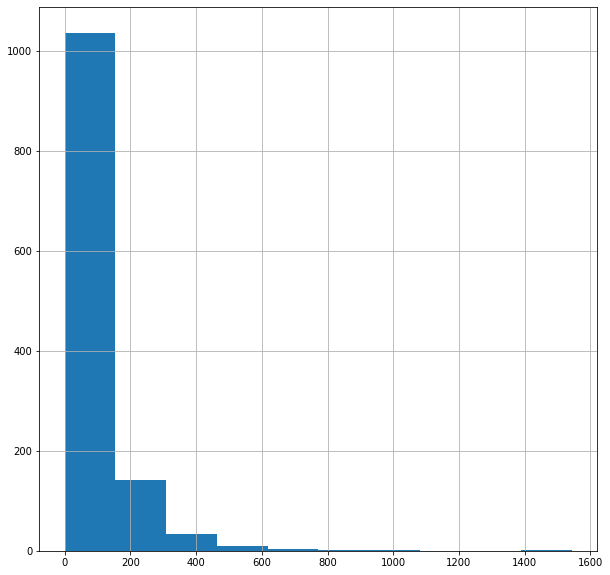

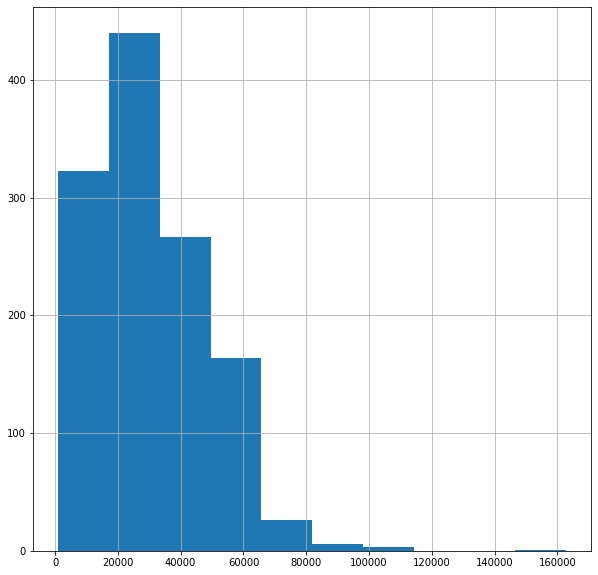

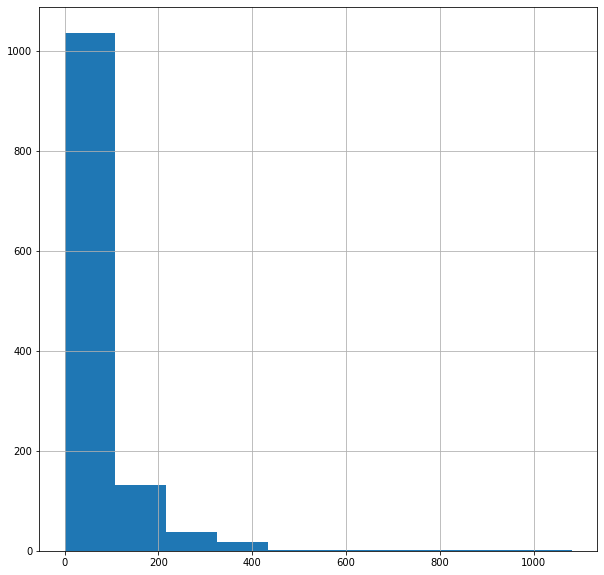

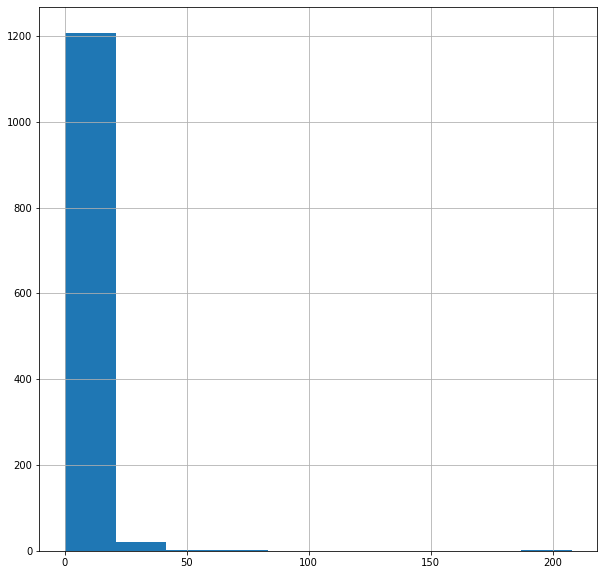

In [124]:
news['likes_count'].hist(figsize=(10, 10,))
plt.show()
news['views_count'].hist(figsize=(10, 10,))
plt.show()
news['comments_count'].hist(figsize=(10, 10,))
plt.show()
news['reposts_count'].hist(figsize=(10, 10,))
plt.show()

/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


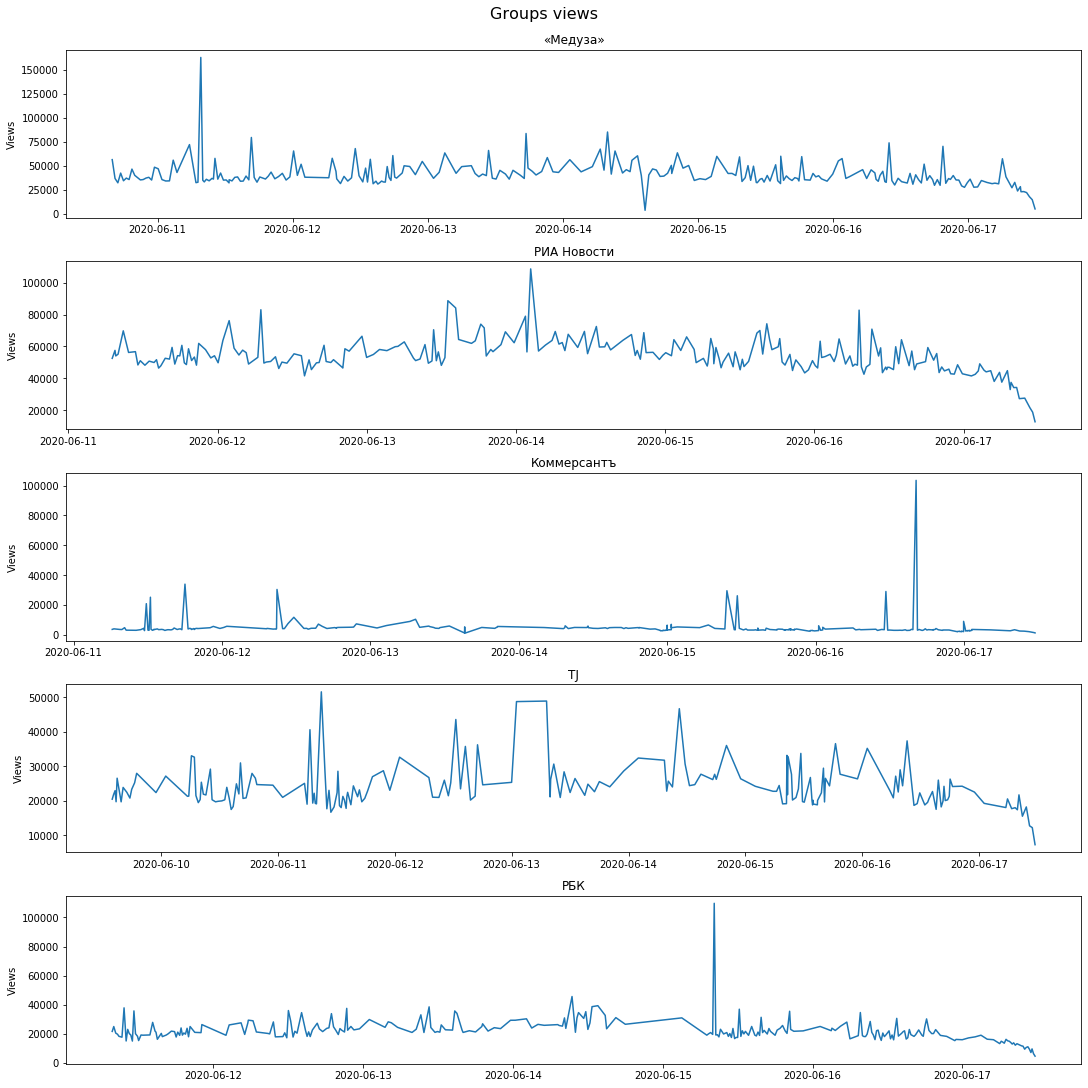

In [154]:
fig, axs = plt.subplots(len(groups), 1, figsize=(15,15), constrained_layout=True)
fig.suptitle('Groups views', fontsize=16)

for i, group in enumerate(groups_df.iterrows()):
    data = news.sort_values(by=['date'], ascending=False)[news['group']==group[1][1]]
    axs[i].plot(data['date'], data['views_count'])
    axs[i].set_title(group[1][0])
    axs[i].set_ylabel('Views')

plt.show()

/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


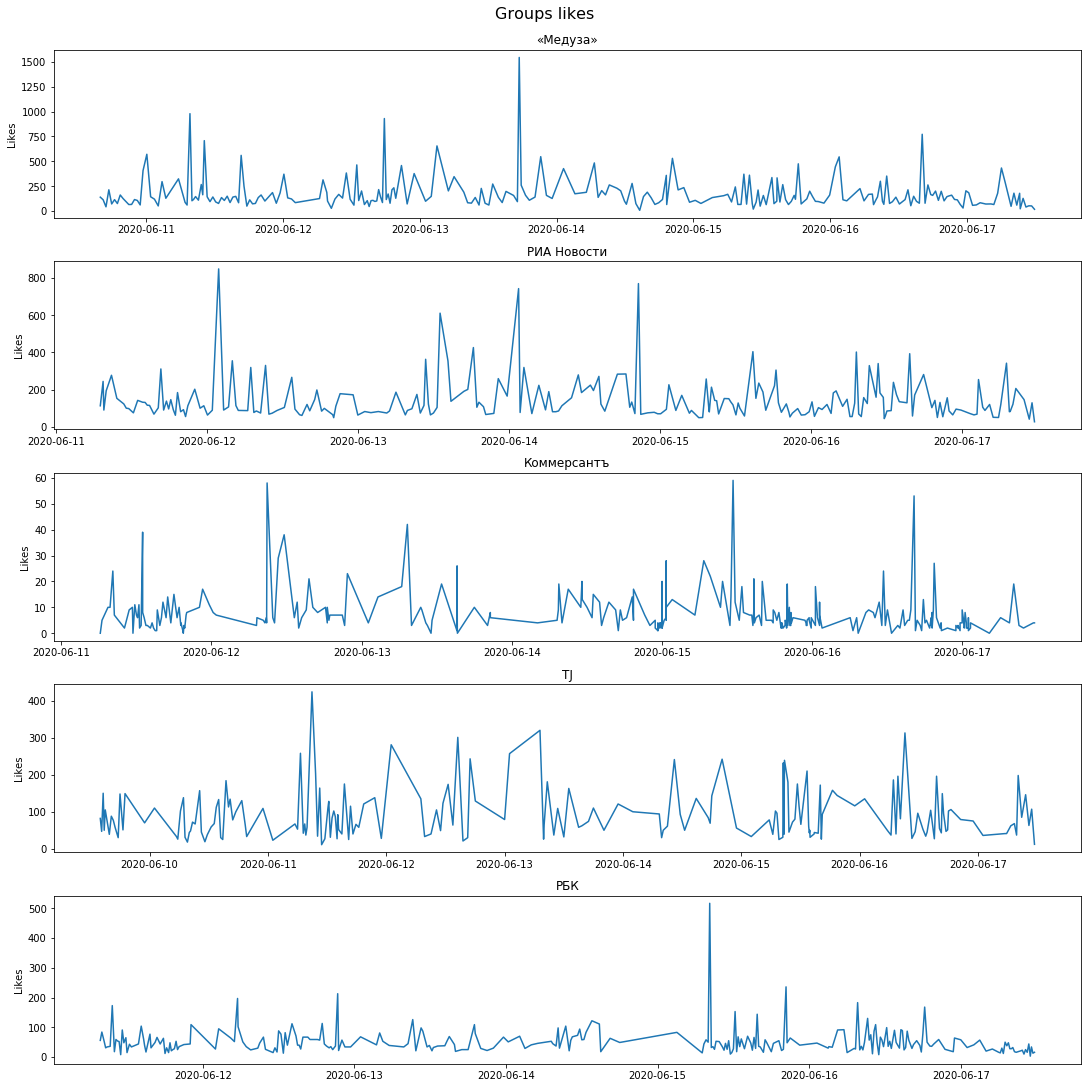

In [155]:
fig, axs = plt.subplots(len(groups), 1, figsize=(15,15), constrained_layout=True)
fig.suptitle('Groups likes', fontsize=16)

for i, group in enumerate(groups_df.iterrows()):
    data = news.sort_values(by=['date'], ascending=False)[news['group']==group[1][1]]
    axs[i].plot(data['date'], data['likes_count'])
    axs[i].set_title(group[1][0])
    axs[i].set_ylabel('Likes')

plt.show()

/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


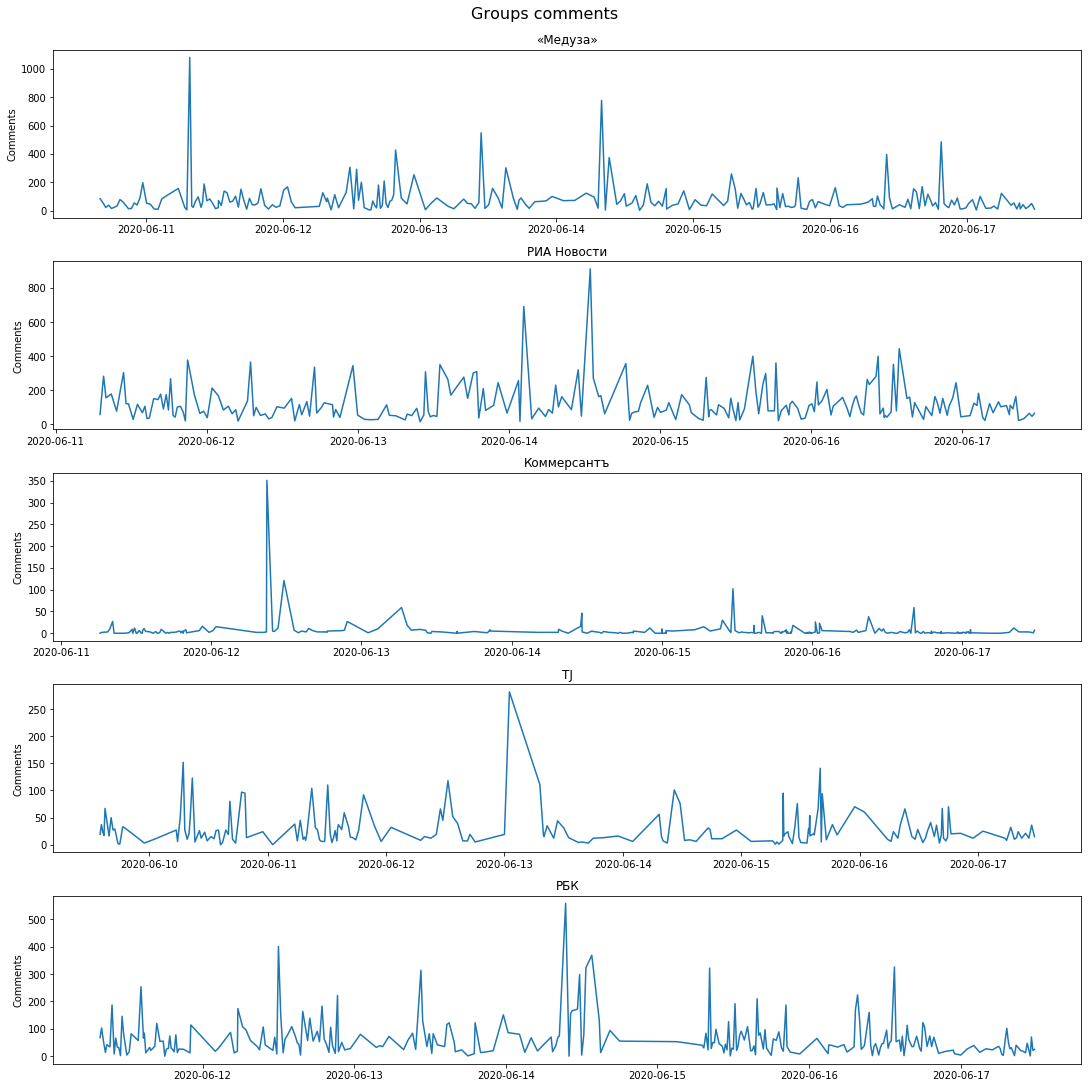

In [156]:
fig, axs = plt.subplots(len(groups), 1, figsize=(15,15), constrained_layout=True)
fig.suptitle('Groups comments', fontsize=16)

for i, group in enumerate(groups_df.iterrows()):
    data = news.sort_values(by=['date'], ascending=False)[news['group']==group[1][1]]
    axs[i].plot(data['date'], data['comments_count'])
    axs[i].set_title(group[1][0])
    axs[i].set_ylabel('Comments')

plt.show()

/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/leadness/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


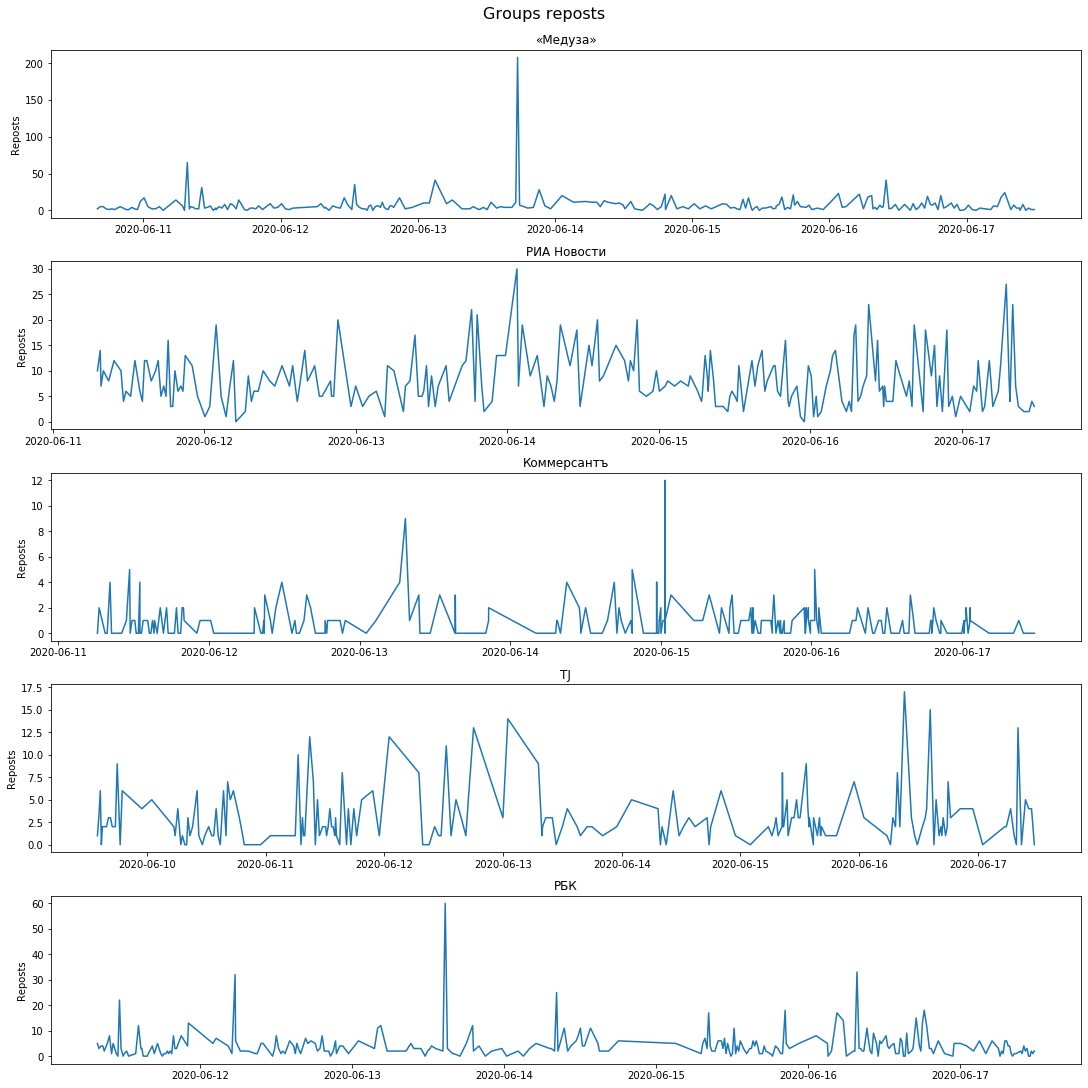

In [157]:
fig, axs = plt.subplots(len(groups), 1, figsize=(15,15), constrained_layout=True)
fig.suptitle('Groups reposts', fontsize=16)

for i, group in enumerate(groups_df.iterrows()):
    data = news.sort_values(by=['date'], ascending=False)[news['group']==group[1][1]]
    axs[i].plot(data['date'], data['reposts_count'])
    axs[i].set_title(group[1][0])
    axs[i].set_ylabel('Reposts')

plt.show()

In [48]:
words_df = pd.DataFrame({
        'word': [],
        'likes': [],
        'views': [],
        'comments': [],
        'reposts': []
    })
words_df

,word,likes,views,comments,reposts


In [56]:
for column in news.columns[12:]:
    row = {
        'word': column,
        'likes': news[news[column]==1]['likes_count'].sum(),
        'views': news[news[column]==1]['views_count'].sum(),
        'comments': news[news[column]==1]['comments_count'].sum(),
        'reposts': news[news[column]==1]['reposts_count'].sum()
    }
    for group in groups_df.iterrows():
        row[group[1][0]] = len(news[(news[column]==1) & (news['group']==group[1][1])]) 
    words_df = words_df.append(row, ignore_index=True)
words_df

,word,likes,views,comments,reposts,TJ,«Медуза»,Коммерсантъ,РБК,РИА Новости
0,10,300.0,90245.0,159.0,22.0,0.0,2.0,1.0,1.0,0.0
1,11,332.0,88043.0,68.0,3.0,1.0,1.0,2.0,1.0,0.0
2,12,266.0,84653.0,154.0,3.0,1.0,2.0,1.0,0.0,0.0
3,1200,100.0,25657.0,51.0,1.0,0.0,1.0,0.0,0.0,0.0
4,14,241.0,78474.0,138.0,7.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1807,яндекса,3.0,3038.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0
1808,яндекскуколд,477.0,85259.0,538.0,10.0,1.0,1.0,0.0,0.0,0.0
1809,яндексу,78.0,19850.0,35.0,1.0,0.0,0.0,1.0,1.0,0.0
1810,ясно,3.0,2451.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0


In [58]:
words_df['likes2views'] = words_df['likes'] / words_df['views']
words_df['comments2views'] = words_df['comments'] / words_df['views']
words_df

,word,likes,views,comments,reposts,TJ,«Медуза»,Коммерсантъ,РБК,РИА Новости,likes2views,comments2views
0,10,300.0,90245.0,159.0,22.0,0.0,2.0,1.0,1.0,0.0,0.003324,0.001762
1,11,332.0,88043.0,68.0,3.0,1.0,1.0,2.0,1.0,0.0,0.003771,0.000772
2,12,266.0,84653.0,154.0,3.0,1.0,2.0,1.0,0.0,0.0,0.003142,0.001819
3,1200,100.0,25657.0,51.0,1.0,0.0,1.0,0.0,0.0,0.0,0.003898,0.001988
4,14,241.0,78474.0,138.0,7.0,0.0,2.0,0.0,0.0,0.0,0.003071,0.001759
...,...,...,...,...,...,...,...,...,...,...,...,...
1807,яндекса,3.0,3038.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.000987,0.001317
1808,яндекскуколд,477.0,85259.0,538.0,10.0,1.0,1.0,0.0,0.0,0.0,0.005595,0.006310
1809,яндексу,78.0,19850.0,35.0,1.0,0.0,0.0,1.0,1.0,0.0,0.003929,0.001763
1810,ясно,3.0,2451.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.001224,0.001224


In [62]:
words_df = words_df.dropna()

In [64]:
# Most liked are news with words below in title
words_df.sort_values(by=['likes2views'], ascending=False).head(10)

,word,likes,views,comments,reposts,TJ,«Медуза»,Коммерсантъ,РБК,РИА Новости,likes2views,comments2views
796,москвичу,598.0,45091.0,165.0,28.0,0.0,1.0,0.0,0.0,0.0,0.013262,0.003659
1733,хочешь,598.0,45091.0,165.0,28.0,0.0,1.0,0.0,0.0,0.0,0.013262,0.003659
1408,себя,599.0,48041.0,168.0,28.0,0.0,1.0,1.0,0.0,0.0,0.012469,0.003497
1072,подбросить,943.0,76000.0,258.0,43.0,1.0,1.0,0.0,0.0,0.0,0.012408,0.003395
363,громко,943.0,76000.0,258.0,43.0,1.0,1.0,0.0,0.0,0.0,0.012408,0.003395
34,720,437.0,37709.0,45.0,14.0,0.0,1.0,0.0,0.0,0.0,0.011589,0.001193
1698,фбк,437.0,37709.0,45.0,14.0,0.0,1.0,0.0,0.0,0.0,0.011589,0.001193
855,недвижимость,437.0,37709.0,45.0,14.0,0.0,1.0,0.0,0.0,0.0,0.011589,0.001193
1608,тот,345.0,30909.0,93.0,15.0,1.0,0.0,0.0,0.0,0.0,0.011162,0.003009
804,мужчине,345.0,30909.0,93.0,15.0,1.0,0.0,0.0,0.0,0.0,0.011162,0.003009


In [65]:
# Most discussed are news with words below in title
words_df.sort_values(by=['comments2views'], ascending=False).head(10)

,word,likes,views,comments,reposts,TJ,«Медуза»,Коммерсантъ,РБК,РИА Новости,likes2views,comments2views
534,извиняться,49.0,21241.0,244.0,6.0,0.0,0.0,0.0,0.0,1.0,0.002307,0.011487
408,доля,81.0,21338.0,235.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003796,0.011013
226,вдвое,81.0,21338.0,235.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003796,0.011013
1169,почти,81.0,21338.0,235.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003796,0.011013
177,безусловных,81.0,21338.0,235.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003796,0.011013
523,знать,63.0,37498.0,401.0,8.0,0.0,0.0,0.0,2.0,0.0,0.001680,0.010694
451,жесткие,101.0,27626.0,284.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003656,0.010280
224,ввести,101.0,27626.0,284.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003656,0.010280
1167,похороны,17.0,20366.0,196.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000835,0.009624
1714,фоторепортаж,17.0,20366.0,196.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000835,0.009624


In [71]:
words_df[['likes', 'comments', 'reposts', 'views']].corr()

,likes,comments,reposts,views
likes,1.000000,0.903448,0.943461,0.977955
comments,0.903448,1.000000,0.938303,0.908972
reposts,0.943461,0.938303,1.000000,0.928201
views,0.977955,0.908972,0.928201,1.000000
